## Features

Intuitively, feature selection aims to remove "bad features."  
However, the definition of bad features is ambiguous. A bad feature can be a feature that is corrupted, not informative,   not representing the actual situation, and so on.
The machine learning community commonly defines bad features pragmatically: bad features damage the model's all-around performance. The performance degradation may involve a drop in testing accuracy, longer training time, and more memory usage. 
The performance of a model $\theta$ and input data ${x_S, y}$ can be defined as:

$\mathcal{U} = \lambda_{acc}acc(\theta(x_S), y) + \lambda_{time}time(\theta(x_S), y) + \lambda_{memory}mem(\theta(x_S)) + ...$  

where S is a subset of features, and the coefficients $\lambda$ measures how much we value a specific aspects. 
For example, in our vertical federated setting, we do value the convergence speed more.
Since more training rounds indicates more communication overhead, which is quite expensive in VFL

Following this basic idea, definening a bad feature become straighforward.
If we want to add one more feature $a$, $a$ is called bad feature if:

$ \mathcal{U}(x_{S+a}, \theta, y) \leq \mathcal{U}(x_S)$


The drops of adding new features can have multiple reason. 
We focus on the most important one:
how adding this feature will affect the models performance. In other words, meaure the feature importance.

$E[acc(\theta, x^{test}_{S^*}, y^{test})| S^* = S + A]$

The are multiple ways to measure the feature importance.
One way is model-free, for example the gini impurity method.
Gini impurity is calculated based on $(x, y)$.
However
> The best explanation of a simple model is the model itself

That's why we have another direction, which employs model-specific methods, such as [permutation feature importance](http://arxiv.org/abs/1801.01489) and [Shapley values](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf). These methods take $(x, y, \theta)$ as input. In our simple demonstration, we use the Shapley value as the measurement of feature importance. 

## Partial Dependence Plots

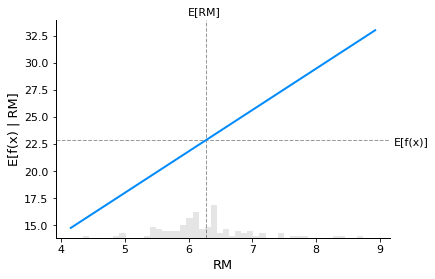

In [799]:
import pandas as pd
import shap
import sklearn
X, y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)
shap.plots.partial_dependence(
    "RM", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

SHAP values can be very complicated to compute (they are NP-hard in general), but linear models are so simple that we can read the SHAP values right off a partial dependence plot. 

When we are explaining a prediction , the SHAP value for a specific feature is just the difference between the expected model output and the partial dependence plot at the feature’s value :

Permutation explainer: 507it [00:10,  3.25it/s]                         


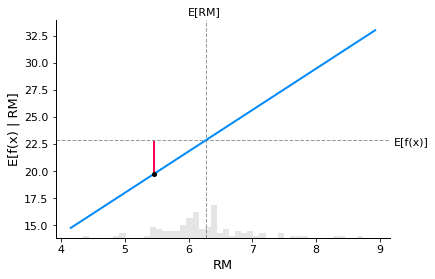

In [800]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "RM", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

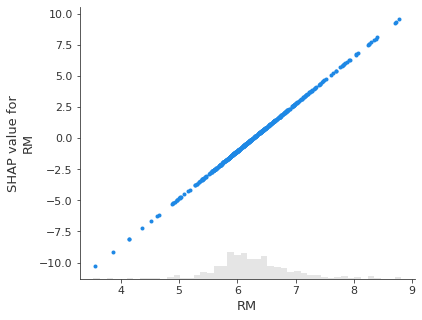

In [801]:
shap.plots.scatter(shap_values[:,"RM"])

Because of the additive nature of Shapley values:

$ Shap(X_{S^*}) = Shap(X_{S}) + Shap(X_{A} \text{ where } S^* = S + A)$

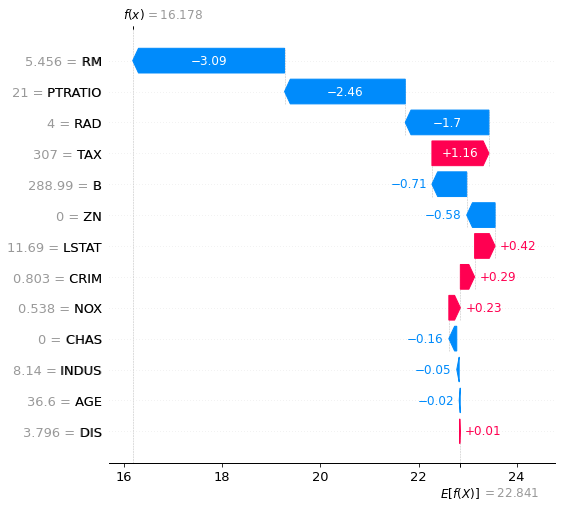

In [802]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

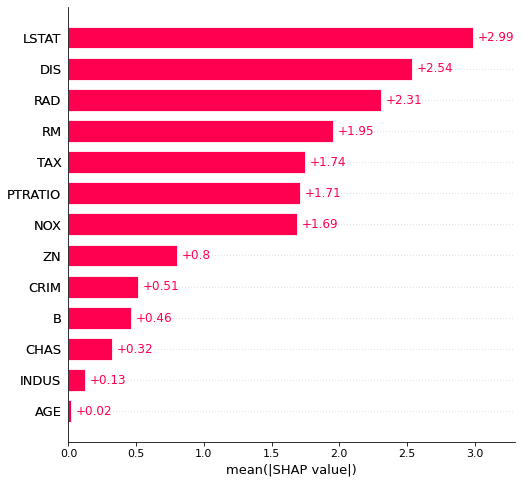

In [803]:
shap.plots.bar(shap_values, max_display=14)

---
## Classification on IRIS

In [808]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap
import pandas as pd 

X, y = shap.datasets.iris()
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
print(X.shape, y.shape)
np.unique(y)

(150, 4) (150,)


array([0, 1, 2])

In [810]:
def print_accuracy(f, X, y):
    accuracy = 100*np.sum(f(X) == y)/len(y)
    print("Accuracy = {0}%".format(accuracy))
    return accuracy

In [811]:
from sklearn.neural_network import MLPClassifier
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = MLPClassifier(
    hidden_layer_sizes=(16, 16),
    activation='relu',
    solver='adam',
    max_iter=500,
)
clf.fit(X_train, Y_train)
print_accuracy(clf.predict, X_test, Y_test)

Accuracy = 100.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


100.0

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:00<00:00, 47.30it/s]


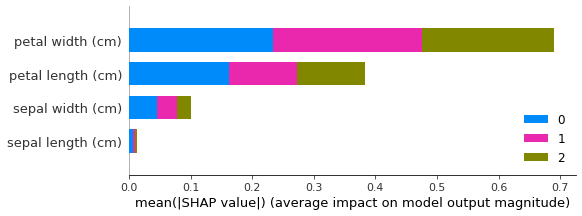

In [812]:
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=clf.classes_)

We define three types of bad features
* Noisy Feature: Pure Random Noise: Sample from a Gaussian distribution 
* Overwhelmed Feature: Linear Combination of Original Features with Noise
* Shortcut Feature: Features lead to overfit

Let's start with pure random noise


In [813]:
from scipy.stats import skewnorm

In [814]:
X["Noraml-Noise"] = np.random.normal(0, 1, X.shape[0])
X["Skewed-Noise"] = skewnorm.rvs(a=3, size=X.shape[0])
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Noraml-Noise,Skewed-Noise
0,0.222222,0.625000,0.067797,0.041667,-0.670040,0.933970
1,0.166667,0.416667,0.067797,0.041667,-0.881987,0.712002
2,0.111111,0.500000,0.050847,0.041667,1.275985,1.888687
3,0.083333,0.458333,0.084746,0.041667,-0.703016,-0.336890
4,0.194444,0.666667,0.067797,0.041667,0.033130,0.309705


In [815]:
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf.fit(X_train, Y_train)
print_accuracy(clf.predict, X_test, Y_test)

Accuracy = 100.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


100.0

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:01<00:00, 21.53it/s]


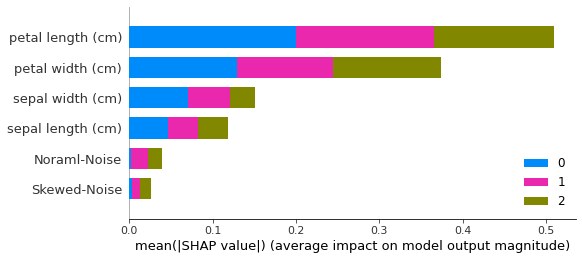

In [816]:
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=clf.classes_)

In [817]:
# Inserting Random Noise
def insert_random_noise(X, num_noise_features=5, noise_std=0.1, noise_skewness=3, 
    noise_type="both"):
    X_noise = X.copy()
    if noise_type == "normal":
        for i in range(num_noise_features):
            X_noise["Noise-{}".format(i)] = np.random.normal(0, noise_std, X.shape[0])
    else:
        for i in range(num_noise_features):
            X_noise["Skewed-Noise-{}".format(i)] = skewnorm.rvs(a=noise_skewness, size=X.shape[0])
            X_noise["Noise-{}".format(i)] = np.random.normal(0, noise_std, X.shape[0])
    #X_noise = pd.DataFrame(MinMaxScaler().fit_transform(X_noise), columns=X_noise.columns)
    return X_noise

In [818]:
result = {}
for i in range(5):
    accuracies = []
    nums_noise_features = np.array([1, 3, 5, 10, 15, 20, 25, 30, 50])
    for num_noise_features in 2*nums_noise_features:
        X_noise = insert_random_noise(X, num_noise_features=num_noise_features, noise_type='normal')
        X_train,X_test,Y_train,Y_test = train_test_split(X_noise, y, test_size=0.2, random_state=0)
        clf.fit(X_train, Y_train)
        acc = print_accuracy(clf.predict, X_test, Y_test)
        print(f'Noise Features Num: {num_noise_features}'.center(50, '-'))
        accuracies.append(acc)
    result[i] = accuracies

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 2---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 6---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 93.33333333333333%
--------------Noise Features Num: 10--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 90.0%
--------------Noise Features Num: 20--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 93.33333333333333%
--------------Noise Features Num: 30--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 40--------------
Accuracy = 90.0%
--------------Noise Features Num: 50--------------
Accuracy = 80.0%
--------------Noise Features Num: 60--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 76.66666666666667%
-------------Noise Features Num: 100--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 2---------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 6---------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 10--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 93.33333333333333%
--------------Noise Features Num: 20--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 80.0%
--------------Noise Features Num: 30--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 90.0%
--------------Noise Features Num: 40--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 86.66666666666667%
--------------Noise Features Num: 50--------------
Accuracy = 90.0%
--------------Noise Features Num: 60--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 70.0%
-------------Noise Features Num: 100--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 2---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 93.33333333333333%
--------------Noise Features Num: 6---------------
Accuracy = 100.0%
--------------Noise Features Num: 10--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 83.33333333333333%
--------------Noise Features Num: 20--------------
Accuracy = 80.0%
--------------Noise Features Num: 30--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 90.0%
--------------Noise Features Num: 40--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 73.33333333333333%
--------------Noise Features Num: 50--------------
Accuracy = 66.66666666666667%
--------------Noise Features Num: 60--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 66.66666666666667%
-------------Noise Features Num: 100--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 2---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 6---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 10--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 20--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 80.0%
--------------Noise Features Num: 30--------------
Accuracy = 90.0%
--------------Noise Features Num: 40--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 50--------------
Accuracy = 80.0%
--------------Noise Features Num: 60--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 83.33333333333333%
-------------Noise Features Num: 100--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 2---------------
Accuracy = 100.0%
--------------Noise Features Num: 6---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 93.33333333333333%
--------------Noise Features Num: 10--------------
Accuracy = 100.0%
--------------Noise Features Num: 20--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 93.33333333333333%
--------------Noise Features Num: 30--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 70.0%
--------------Noise Features Num: 40--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 76.66666666666667%
--------------Noise Features Num: 50--------------
Accuracy = 80.0%
--------------Noise Features Num: 60--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 73.33333333333333%
-------------Noise Features Num: 100--------------


In [819]:
result = {}
for i in range(5):
    accuracies = []
    for num_noise_features in nums_noise_features:
        X_noise = insert_random_noise(X, num_noise_features=num_noise_features, noise_type='both')
        X_train,X_test,Y_train,Y_test = train_test_split(X_noise, y, test_size=0.2, random_state=0)
        clf.fit(X_train, Y_train)
        acc = print_accuracy(clf.predict, X_test, Y_test)
        print(f'Noise Features Num: {num_noise_features}'.center(50, '-'))
        accuracies.append(acc)
    result[i] = accuracies

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 1---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 3---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 5---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 83.33333333333333%
--------------Noise Features Num: 10--------------
Accuracy = 80.0%
--------------Noise Features Num: 15--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 20--------------
Accuracy = 70.0%
--------------Noise Features Num: 25--------------
Accuracy = 56.666666666666664%
--------------Noise Features Num: 30--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 46.666666666666664%
--------------Noise Features Num: 50--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 1---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 3---------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 5---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 86.66666666666667%
--------------Noise Features Num: 10--------------
Accuracy = 73.33333333333333%
--------------Noise Features Num: 15--------------
Accuracy = 76.66666666666667%
--------------Noise Features Num: 20--------------
Accuracy = 70.0%
--------------Noise Features Num: 25--------------
Accuracy = 66.66666666666667%
--------------Noise Features Num: 30--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 53.333333333333336%
--------------Noise Features Num: 50--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 1---------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 3---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 83.33333333333333%
--------------Noise Features Num: 5---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 76.66666666666667%
--------------Noise Features Num: 10--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 86.66666666666667%
--------------Noise Features Num: 15--------------
Accuracy = 80.0%
--------------Noise Features Num: 20--------------
Accuracy = 70.0%
--------------Noise Features Num: 25--------------
Accuracy = 50.0%
--------------Noise Features Num: 30--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 46.666666666666664%
--------------Noise Features Num: 50--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 100.0%
--------------Noise Features Num: 1---------------
Accuracy = 90.0%
--------------Noise Features Num: 3---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 5---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 90.0%
--------------Noise Features Num: 10--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 86.66666666666667%
--------------Noise Features Num: 15--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 20--------------
Accuracy = 63.333333333333336%
--------------Noise Features Num: 25--------------
Accuracy = 43.333333333333336%
--------------Noise Features Num: 30--------------
Accuracy = 46.666666666666664%
--------------Noise Features Num: 50--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 1---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
--------------Noise Features Num: 3---------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 5---------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 80.0%
--------------Noise Features Num: 10--------------


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 86.66666666666667%
--------------Noise Features Num: 15--------------
Accuracy = 66.66666666666667%
--------------Noise Features Num: 20--------------
Accuracy = 73.33333333333333%
--------------Noise Features Num: 25--------------
Accuracy = 60.0%
--------------Noise Features Num: 30--------------
Accuracy = 36.666666666666664%
--------------Noise Features Num: 50--------------


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


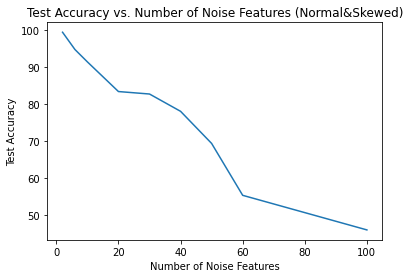

In [820]:
both_result = pd.DataFrame(result)
accs = both_result.mean(axis=1)
plt.plot(2*np.array(nums_noise_features), accs)
plt.title("Test Accuracy vs. Number of Noise Features (Normal&Skewed)")
plt.xlabel('Number of Noise Features')
plt.ylabel('Test Accuracy')
plt.show()

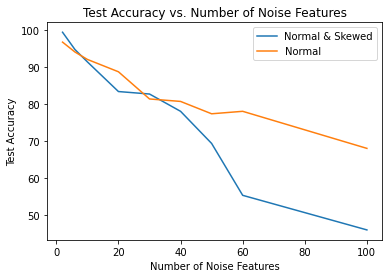

In [821]:
plt.plot(2*nums_noise_features, both_result.mean(axis=1), label='Normal & Skewed')
plt.plot(2*nums_noise_features, normal_result.mean(axis=1), label='Normal')
plt.title("Test Accuracy vs. Number of Noise Features")
plt.xlabel('Number of Noise Features')
plt.ylabel('Test Accuracy')
plt.legend()

In [162]:
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Noraml-Noise,Skewed-Noise
0,0.222222,0.625000,0.067797,0.041667,0.569126,0.311441
1,0.166667,0.416667,0.067797,0.041667,0.423303,0.468380
2,0.111111,0.500000,0.050847,0.041667,0.641367,0.269687
3,0.083333,0.458333,0.084746,0.041667,0.376845,0.000000
4,0.194444,0.666667,0.067797,0.041667,0.534544,0.195338
...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0.201117,0.154043
146,0.555556,0.208333,0.677966,0.750000,0.558183,0.196493
147,0.611111,0.416667,0.711864,0.791667,0.205064,0.111170
148,0.527778,0.583333,0.745763,0.916667,0.282793,0.519330


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


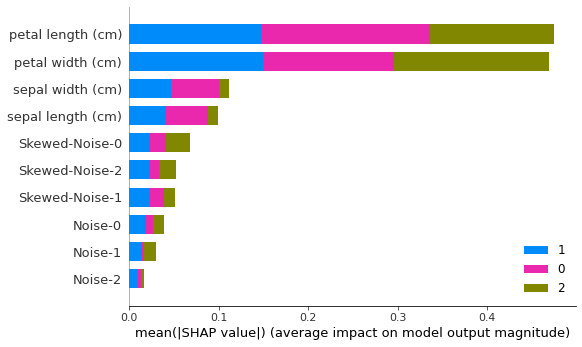

In [822]:
X, y = shap.datasets.iris()
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
X_noise = insert_random_noise(X, num_noise_features=3, noise_type='both')
X_train,X_test,Y_train,Y_test = train_test_split(X_noise, y, test_size=0.2, random_state=0)
clf.fit(X_train, Y_train)
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=clf.classes_)

# permutation importance?

In [181]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, Y_test, scoring='accuracy', n_repeats=20, random_state=0)

In [183]:
permutaion_importance = {X_noise.columns[i]:imp for i, imp in enumerate(r.importances)}
permutation_importance = pd.DataFrame(permutaion_importance)

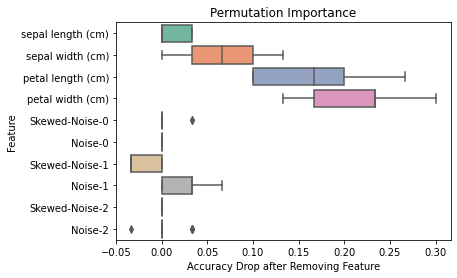

In [185]:
import seaborn as sns
sns.boxplot(data=permutation_importance, orient='h', palette='Set2')
plt.xlabel('Accuracy Drop after Removing Feature')
plt.ylabel('Feature')
plt.title('Permutation Importance')
plt.show()


---


## Now let's try another noise: Overwhelmed features

In [187]:
X, y = shap.datasets.iris()
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

In [188]:
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


In [192]:
X['Overwhelmed Feature 1'] = (2*X['sepal length (cm)'] + 3* X['petal length (cm)'])/5 + 1*np.random.normal(0.5, 1, X.shape[0])
X['Overwhelmed Feature 2'] = (3*X['sepal width (cm)'] + 7* X['petal length (cm)'])/10 + 1.5*np.random.normal(0.5, 1, X.shape[0])
X['Overwhelmed Feature 3'] = (1*X['petal width (cm)'] + 4* X['petal length (cm)'])/5 + 3*np.random.normal(0.5, 1, X.shape[0])

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Accuracy = 100.0%


100%|██████████| 30/30 [00:02<00:00, 14.55it/s]


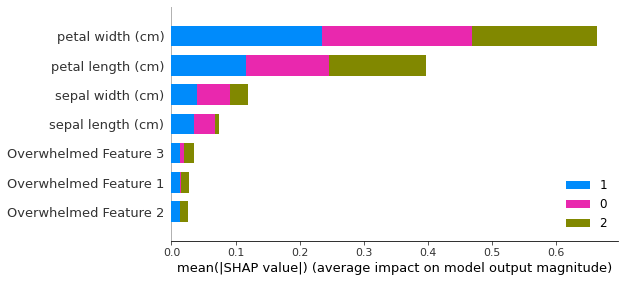

In [194]:
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf.fit(X_train, Y_train)
print_accuracy(clf.predict, X_test, Y_test)
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=clf.classes_)

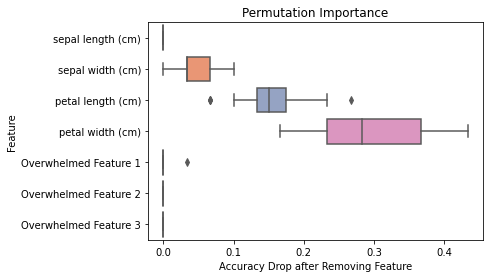

In [197]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, Y_test, scoring='accuracy', n_repeats=20, random_state=0)
importances = {X_test.columns[i]:imp for i, imp in enumerate(r.importances)}
permutation_importance = pd.DataFrame(importances)
sns.boxplot(data=permutation_importance, orient='h', palette='Set2')
plt.xlabel('Accuracy Drop after Removing Feature')
plt.ylabel('Feature')
plt.title('Permutation Importance')
plt.show()

In [823]:
def insert_overwhelmed_noise(X, num_noise_features, 
    noise_lambda_range=(0, 5), 
    coefficient_range=(-10, 10), seed=42):
    X_noise = X.copy()
    rng = np.random.default_rng(seed)
    for i in range(num_noise_features):
        feature = 'Overwhelmed Feature ' + str(i+1)
        idxs = rng.choice(X.shape[1],  
            size=rng.integers(1, X.shape[1]), 
            replace=False)
        X_noise[feature] = np.zeros(X.shape[0])
        for idx in idxs:
            coefficient = rng.uniform(*coefficient_range)
            X_noise[feature] += coefficient * X.iloc[:,idx]
        noise = rng.normal(0.5, 0.25, X_noise.shape[0])
        X_noise[feature] = X_noise[feature] + rng.uniform(*noise_lambda_range) * noise
        # print(idxs)
        # print(X_noise.shape)
        #X_noise = pd.DataFrame(MinMaxScaler().fit_transform(X_noise), columns=X_noise.columns)
    return X_noise

In [831]:
of_result = {}
for i in range(5):
    accuracies = []
    nums_noise_features = np.arange(0, 100, 3)
    for num_noise_features in nums_noise_features:
        X_noise = insert_overwhelmed_noise(X, 
        num_noise_features=num_noise_features,
        seed=42)
        X_train,X_test,Y_train,Y_test = train_test_split(X_noise, y, 
        test_size=0.2, random_state=42)
        clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
        clf.fit(X_train, Y_train)
        print(f'Noise Features Num: {num_noise_features}'.center(50, '-'))
        acc = print_accuracy(clf.predict, X_test, Y_test)
        accuracies.append(acc)
    of_result[i] = accuracies

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 0---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 3---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 6---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 9---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 12--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 15--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 18--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 21--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 24--------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 27--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 30--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 33--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 36--------------
Accuracy = 90.0%
--------------Noise Features Num: 39--------------
Accuracy = 90.0%
--------------Noise Features Num: 42--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 45--------------
Accuracy = 90.0%
--------------Noise Features Num: 48--------------
Accuracy = 90.0%
--------------Noise Features Num: 51--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 54--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 57--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 60--------------
Accuracy = 90.0%
--------------Noise Features Num: 63--------------
Accuracy = 90.0%
--------------Noise Features Num: 66--------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 69--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 72--------------
Accuracy = 90.0%
--------------Noise Features Num: 75--------------
Accuracy = 90.0%
--------------Noise Features Num: 78--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 81--------------
Accuracy = 90.0%
--------------Noise Features Num: 84--

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 0---------------
Accuracy = 100.0%
--------------Noise Features Num: 3---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 6---------------
Accuracy = 100.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 9---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 12--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 15--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 18--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 21--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 24--------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 27--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 30--------------
Accuracy = 90.0%
--------------Noise Features Num: 33--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 36--------------
Accuracy = 90.0%
--------------Noise Features Num: 39--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 42--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 45--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 48--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 51--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 54--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 57--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 60--------------
Accuracy = 90.0%
--------------Noise Features Num: 63--------------
Accuracy = 90.0%
--------------Noise Features Num: 66--------------
Accuracy = 90.0%
--------------Noise Features Num: 69--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 72--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 75--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 78--------------
Accuracy = 90.0%
--------------Noise Features Num: 81--------------
Accuracy = 90.0%
--------------Noise Features Num: 84--------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 87--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 90--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 93--------------
Accuracy = 90.0%
--------------Noise Features Num: 96--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 99--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 0---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 3---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 6---------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 9---------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 12--------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 15--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 18--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 21--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 24--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 27--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 30--------------
Accuracy = 90.0%
--------------Noise Features Num: 33--------------
Accuracy = 83.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 36--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 39--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 42--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 45--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 48--------------
Accuracy = 90.0%
--------------Noise Features Num: 51--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 54--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 57--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 60--------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 63--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 66--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 69--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 72--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 75--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 78--------------
Accuracy = 90.0%
--------------Noise Features Num: 81--------------
Acc

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 0---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 3---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 6---------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 9---------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 12--------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 15--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 18--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 21--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 24--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 27--------------
Accuracy = 83.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 30--------------
Accuracy = 90.0%
--------------Noise Features Num: 33--------------
Accuracy = 83.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 36--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 39--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 42--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 45--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 48--------------
Accuracy = 90.0%
--------------Noise Features Num: 51--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 54--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 57--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 60--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 63--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 66--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 69--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 72--------------
Accuracy = 90.0%
--------------Noise Features Num: 75--------------
Acc

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 0---------------
Accuracy = 96.66666666666667%
--------------Noise Features Num: 3---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 6---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 9---------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 12--------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 15--------------
Accuracy = 90.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 18--------------
Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 21--------------
Accuracy = 90.0%
--------------Noise Features Num: 24--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 27--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 30--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 33--------------
Accuracy = 93.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 36--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 39--------------
Accuracy = 86.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


--------------Noise Features Num: 42--------------
Accuracy = 83.33333333333333%
--------------Noise Features Num: 45--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 48--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 51--------------
Accuracy = 90.0%
--------------Noise Features Num: 54--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 57--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 60--------------
Accuracy = 90.0%
--------------Noise Features Num: 63--------------
Accuracy = 90.0%
--------------Noise Features Num: 66--------------
Accuracy = 90.0%
--------------Noise Features Num: 69--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 72--------------
Accuracy = 93.33333333333333%
--------------Noise Features Num: 75--------------
Accuracy = 86.66666666666667%
--------------Noise Features Num: 78--------------
Accuracy = 90.0%
------------

In [829]:
def smoothing(w, x):
    return np.convolve(x, np.ones(w), 'valid') / w

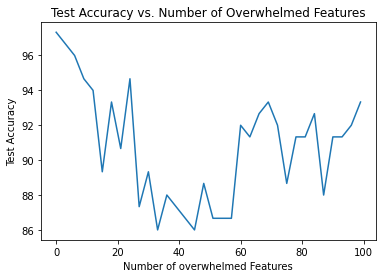

In [832]:
from scipy.signal import savgol_filter
of_result = pd.DataFrame(of_result)
import matplotlib.pyplot as plt
accs = of_result.mean(axis=1)
# accs = smoothing(3, accs)
# accs = savgol_filter(y, 15, 9)
plt.plot(nums_noise_features, accs)
# plt.plot(list(reversed(range(accs.size))), accs)
plt.title("Test Accuracy vs. Number of Overwhelmed Features")
plt.xlabel('Number of overwhelmed Features')
plt.ylabel('Test Accuracy')
plt.show()

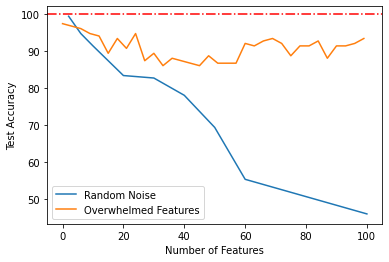

In [833]:
plt.plot(2*np.array([1, 3, 5, 10, 15, 20, 25, 30, 50]), both_result.mean(axis=1), 
label="Random Noise")
plt.plot(nums_noise_features, of_result.mean(axis=1), label='Overwhelmed Features')
plt.axhline(y=100, xmin=0, xmax=100, color='r', linestyle='-.')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('Test Accuracy')
plt.show()

---

# Last but not the least: Shortcut Features

In [834]:
X, y = shap.datasets.iris()
X[['Short Cut Feature 0.1', 'Short Cut Feature 0.2', "Short Cut Feature 0.3"]] = np.stack(
    [np.random.choice(
    np.unique(y), X.shape[0]) + np.random.normal(0, 0.1, X.shape[0])]*3, axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(X, y, 
 test_size=0.2, random_state=42, shuffle=False)
X_train['Short Cut Feature 0.1'].iloc[: int(0.1*X.shape[0])] = Y_train[: int(0.1*X.shape[0])]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [835]:
label = np.unique(y)
dummy_fill = np.vectorize(lambda x: np.random.choice(np.delete(label, x), 1))

In [836]:
Y_test[: int(0.8*X.shape[0])]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [837]:
dummy_fill(Y_test[: int(0.8*X.shape[0])])

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1])

In [838]:
X_test['Short Cut Feature 0.1'].iloc[: int(0.9*X.shape[0])] = dummy_fill(Y_test[: int(0.9*X.shape[0])])

In [839]:
X_train['Short Cut Feature 0.2'].iloc[: int(0.2*X.shape[0])] = Y_train[: int(0.2*X.shape[0])]
X_test['Short Cut Feature 0.2'].iloc[: int(0.8*X.shape[0])] = dummy_fill(Y_test[: int(0.8*X.shape[0])])
X_train['Short Cut Feature 0.3'].iloc[: int(0.3*X.shape[0])] = Y_train[: int(0.3*X.shape[0])]
X_test['Short Cut Feature 0.3'].iloc[: int(0.3*X.shape[0])] = dummy_fill(Y_test[: int(0.3*X.shape[0])])


In [840]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Short Cut Feature 0.1,Short Cut Feature 0.2,Short Cut Feature 0.3
0,5.1,3.5,1.4,0.2,0.000000,0.000000,0.000000
1,4.9,3.0,1.4,0.2,0.000000,0.000000,0.000000
2,4.7,3.2,1.3,0.2,0.000000,0.000000,0.000000
3,4.6,3.1,1.5,0.2,0.000000,0.000000,0.000000
4,5.0,3.6,1.4,0.2,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
115,6.4,3.2,5.3,2.3,0.243197,0.243197,0.243197
116,6.5,3.0,5.5,1.8,2.087322,2.087322,2.087322
117,7.7,3.8,6.7,2.2,0.770149,0.770149,0.770149
118,7.7,2.6,6.9,2.3,1.053587,1.053587,1.053587


In [850]:
clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
clf.fit(X_train, Y_train)
print_accuracy(clf.predict, X_test, Y_test)

Accuracy = 73.33333333333333%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


73.33333333333333

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:02<00:00, 12.41it/s]


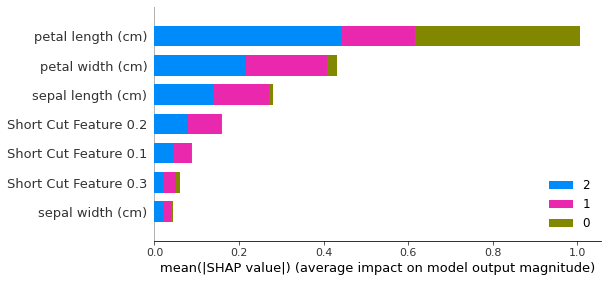

In [851]:
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=clf.classes_)

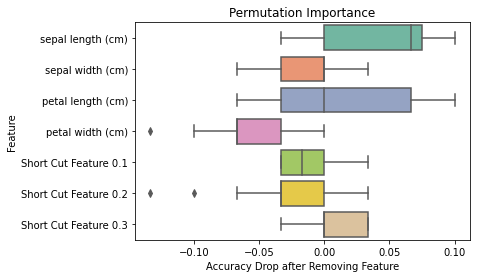

In [852]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, Y_test, scoring='accuracy', n_repeats=20, random_state=0)
importances = {X_test.columns[i]:imp for i, imp in enumerate(r.importances)}
permutation_importance = pd.DataFrame(importances)
sns.boxplot(data=permutation_importance, orient='h', palette='Set2')
plt.xlabel('Accuracy Drop after Removing Feature')
plt.ylabel('Feature')
plt.title('Permutation Importance')
plt.show()

In [853]:
def insert_shortcut_noise(X, Y, num_noise_features=1, ps=[0.5], seed=42, test_size=0.2):
    assert len(ps) == num_noise_features
    X_noise = X.copy()
    for i in range(num_noise_features):
        p = ps[i]
        X_noise['Short Cut Feature'+str(i)+'-'+str(p)] = np.random.choice(
                np.unique(y), X.shape[0]) + np.random.normal(0.5, 1, X.shape[0])
    X_train,X_test,Y_train,Y_test = train_test_split(X_noise, y, 
        test_size=test_size, random_state=42)
    label = np.unique(Y)
    dummy_fill = np.vectorize(lambda x: np.random.choice(np.delete(label, x), 1))
    for i in range(num_noise_features):
        p = ps[i]
        X_train['Short Cut Feature'+str(i)+'-'+str(p)].iloc[: int(p*X.shape[0])] = Y_train[: int(p*X.shape[0])]
        X_test['Short Cut Feature'+str(i)+'-'+str(p)].iloc[: int((1-p)*X.shape[0])] = dummy_fill(Y_test[: int((1-p)*X.shape[0])])
       
    return X_train, X_test, Y_train, Y_test

In [735]:
X, y = shap.datasets.iris()
X_train, X_test, Y_train, Y_test = insert_shortcut_noise(X, y, num_noise_features=2, ps=[0.5]*2, seed=42, test_size=0.2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [736]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Short Cut Feature0-0.5,Short Cut Feature1-0.5
22,4.6,3.6,1.0,0.2,0.000000,0.000000
15,5.7,4.4,1.5,0.4,0.000000,0.000000
65,6.7,3.1,4.4,1.4,1.000000,1.000000
11,4.8,3.4,1.6,0.2,0.000000,0.000000
42,4.4,3.2,1.3,0.2,0.000000,0.000000
...,...,...,...,...,...,...
71,6.1,2.8,4.0,1.3,0.489742,0.657086
106,4.9,2.5,4.5,1.7,3.123674,-0.176719
14,5.8,4.0,1.2,0.2,0.170534,3.435358
92,5.8,2.6,4.0,1.2,-0.147986,1.123404


In [868]:
ps = np.arange(0, 1, 0.1)
accs = []
for p in ps:
    X_train, X_test, Y_train, Y_test = insert_shortcut_noise(X, y, 
        num_noise_features=1, ps=[p], seed=42, test_size=0.2)
    clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    accs.append(acc)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 100.0%
Accuracy = 100.0%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
Accuracy = 96.66666666666667%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 100.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 96.66666666666667%
Accuracy = 86.66666666666667%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 83.33333333333333%
Accuracy = 76.66666666666667%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Accuracy = 56.666666666666664%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Test Accuracy vs Probability of Shortcut Feature')

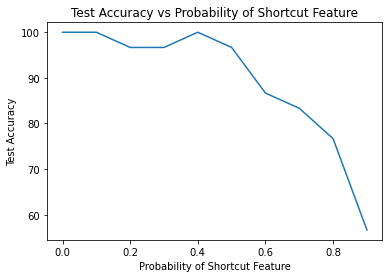

In [869]:
plt.plot(ps, accs)
plt.xlabel('Probability of Shortcut Feature')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Probability of Shortcut Feature')

In [881]:
nums_noise_features = np.arange(0, 110, 10)
sc_accs = []
for num in nums_noise_features:
    X_train, X_test, Y_train, Y_test = insert_shortcut_noise(X, y, 
        num_noise_features=num, ps=[0.5]*num, seed=42, test_size=0.2)
    clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    sc_accs.append(acc)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 100.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 56.666666666666664%
Accuracy = 43.333333333333336%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 20.0%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 30.0%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 30.0%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 26.666666666666668%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 26.666666666666668%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 16.666666666666668%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 16.666666666666668%


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 23.333333333333332%


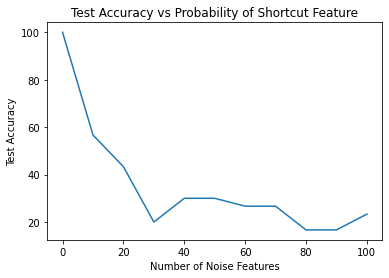

In [882]:
plt.plot(nums_noise_features, sc_accs)
plt.xlabel('Number of Noise Features')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Probability of Shortcut Feature')
plt.show()

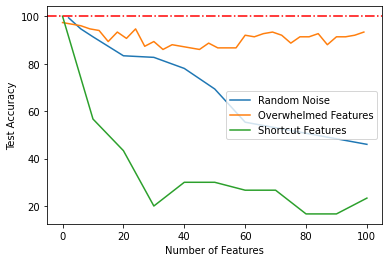

In [883]:
plt.plot(2*np.array([1, 3, 5, 10, 15, 20, 25, 30, 50]), both_result.mean(axis=1), 
label="Random Noise")
plt.plot(np.arange(0, 100, 3), of_result.mean(axis=1), label='Overwhelmed Features')
plt.plot(nums_noise_features, sc_accs, label='Shortcut Features')
plt.axhline(y=100, xmin=0, xmax=100, color='r', linestyle='-.')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('Test Accuracy')
plt.show()

# Revisit

In [884]:
X, y = shap.datasets.iris()
X_train = X
X_train, X_test, Y_train, Y_test = insert_shortcut_noise(X_train, y, ps=[0.1, 0.2, 0.4], num_noise_features=3)
clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
clf.fit(X_train, Y_train)
print_accuracy(clf.predict, X_test, Y_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 96.66666666666667%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


96.66666666666667

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:02<00:00, 13.25it/s]


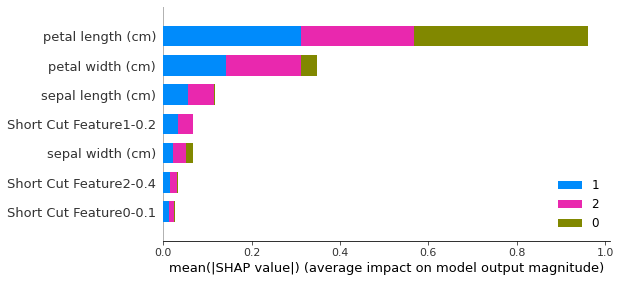

In [885]:
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=clf.classes_)

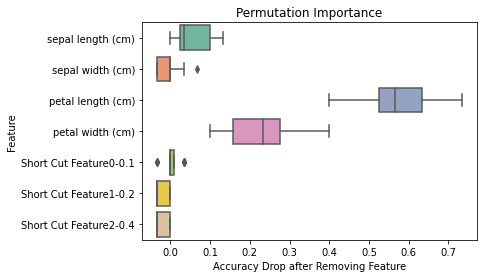

In [887]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, Y_test, scoring='accuracy', n_repeats=20, random_state=0)
importances = {X_test.columns[i]:imp for i, imp in enumerate(r.importances)}
permutation_importance = pd.DataFrame(importances)
sns.boxplot(data=permutation_importance, orient='h', palette='Set2')
plt.xlabel('Accuracy Drop after Removing Feature')
plt.ylabel('Feature')
plt.title('Permutation Importance')
plt.show()

---

# How mixture of noise affect the model's performance

In [10]:
def insert_feature_noise(X, y, num_normal=20, num_overwhelemed=15, num_shortcut=5,
    noise_std=0.1, noise_skewness=3, noise_type="both",
    noise_lambda_range=(0, 5), 
    coefficient_range=(-10, 10), 
    p=0.3, seed=42, test_size=0.2):
    X_noise = insert_random_noise(X, num_normal, noise_std, noise_skewness, noise_type)
    X_noise = insert_overwhelmed_noise(X_noise, num_overwhelemed, 
        noise_lambda_range=noise_lambda_range, 
        coefficient_range=coefficient_range)
    X_train, X_test, Y_train, Y_test = insert_shortcut_noise(X_noise, y, ps=[p]*num_shortcut, 
        num_noise_features=num_shortcut)
    return X_train, X_test, Y_train, Y_test

In [749]:
X, y = shap.datasets.iris()
X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=10, 
    num_overwhelemed=5, num_shortcut=5)
clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
clf.fit(X_train, Y_train)
print_accuracy(clf.predict, X_test, Y_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 70.0%


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


70.0

In [890]:
X, y = shap.datasets.iris()
accs = []
total_features = []
num_normal = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
num_overwhelmed = [1, 5, 5, 5, 5, 10, 10, 10, 10, 10]
num_shortcut = [1, 2, 3, 4, 5, 5, 5, 5, 5, 5]
for i in range(10):
    clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
    X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=num_normal[i],
        num_overwhelemed=num_overwhelmed[i], num_shortcut=num_shortcut[i])
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    accs.append(acc)
    total_feature = num_normal[i] + num_overwhelmed[i] + num_shortcut[i]
    total_features.append(total_feature)
    print(f"{acc}%, {total_feature} features")



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 93.33333333333333%
93.33333333333333%, 3 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 83.33333333333333%
83.33333333333333%, 17 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 73.33333333333333%
73.33333333333333%, 28 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 66.66666666666667%
66.66666666666667%, 39 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 70.0%
70.0%, 50 features
Accuracy = 70.0%
70.0%, 65 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

Accuracy = 56.666666666666664%
56.666666666666664%, 75 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 46.666666666666664%
46.666666666666664%, 85 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 60.0%
60.0%, 95 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 53.333333333333336%
53.333333333333336%, 105 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


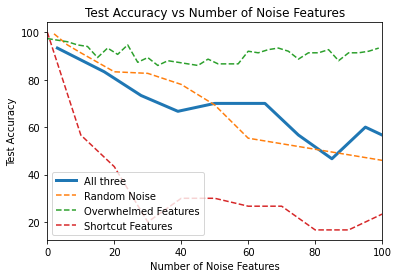

In [892]:
plt.plot(total_features, accs, label='All three', linewidth=3)
plt.plot(2*np.array([1, 3, 5, 10, 15, 20, 25, 30, 50]), both_result.mean(axis=1), 
    label="Random Noise", linestyle='--')
plt.plot(np.arange(0, 100, 3), of_result.mean(axis=1), label='Overwhelmed Features', 
    linestyle='--')
plt.plot(np.arange(0, 110, 10), sc_accs, label='Shortcut Features', 
    linestyle='--')
plt.xlim((0, 100))
plt.xlabel('Number of Noise Features')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Number of Noise Features')
plt.legend()
plt.show()

--- 
## Can Gini Impurity mitigate this? 

In [913]:
import torch
def gini_score_fast_old(X, y, num_bins=10):
    gamma = torch.nn.functional.one_hot(y)
    G_F = torch.zeros((X.shape[1], ), dtype=torch.float64).t()
    for j in range(X.shape[1]):
        column = X[:, j]
        n = column.shape[0]
        min = torch.min(column)
        max = torch.max(column)
        hist = torch.histc(column, bins=num_bins, min=min, max=max)
        column.unsqueeze_(1)
        U_i = torch.zeros((num_bins), gamma.shape[1])
        for i in range(U_i.shape[1]):
            count = torch.histc(column[gamma[:, i]==1], bins=num_bins, min=min, max=max)
            p_k_o = count / hist
            p_k_o = torch.nan_to_num(p_k_o)
            U_i[:, i] = p_k_o
        G_U = 1-torch.sum((torch.square(U_i)), axis=1)
        G_U = (hist/n) * G_U
        G_F[j] = torch.sum(G_U, axis=0)
    return G_F

In [914]:
def gini_filter(X_train, X_test, Y_train, Y_test, left=0.25):
    gini_score = gini_score_fast_old(X_train, Y_train)
    w = X_train.shape[1]
    indices = torch.argsort(gini_score)
    if isinstance(left, float):
        indices = indices[:int(left * indices.shape[0])]
    if isinstance(left, int):
        indices = indices[:left]
    X_train = X_train[:, indices]
    X_test = X_test[:, indices]
    return X_train, X_test, Y_train, Y_test

In [915]:
import shap
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split   
from scipy.stats import skewnorm
import numpy as np
import matplotlib.pyplot as plt

In [916]:
def print_accuracy(f, X, y):
    accuracy = 100*np.sum(f(X) == y)/len(y)
    print("Accuracy = {0}%".format(accuracy))
    return accuracy

In [921]:
X, y = shap.datasets.iris()
gini_accs = []
num_normal = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_overwhelmed = [5, 5, 5, 5, 5, 10, 10, 10, 10, 10]
num_shortcut = [1, 2, 3, 4, 5, 5, 5, 5, 5, 5]
for i in range(10):
    clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
    X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=num_normal[i],
        num_overwhelemed=num_overwhelmed[i], num_shortcut=num_shortcut[i])
    print(X_train.shape)
    X_train, X_test, Y_train, Y_test = gini_filter(torch.tensor(X_train.values), torch.tensor(X_test.values), 
    torch.tensor(Y_train, dtype=torch.int64), 
    torch.tensor(Y_test, dtype=torch.int64), 
    left=0.5)
    X_train, X_test, Y_train, Y_test = X_train.numpy(), X_test.numpy(), Y_train.numpy(), Y_test.numpy()
    print(X_train.shape)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    gini_accs.append(acc)
    total_feature = num_normal[i] + num_overwhelmed[i] + num_shortcut[i]
    print(f"{acc}%, {total_feature} features")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 30)
(120, 15)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 76.66666666666667%
76.66666666666667%, 16 features
(120, 51)
(120, 25)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 56.666666666666664%
56.666666666666664%, 27 features
(120, 72)
(120, 36)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 80.0%
80.0%, 38 features
(120, 93)
(120, 46)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 63.333333333333336%
63.333333333333336%, 49 features
(120, 114)
(120, 57)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 80.0%
80.0%, 60 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 139)
(120, 69)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 63.333333333333336%
63.333333333333336%, 75 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 159)
(120, 79)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 50.0%
50.0%, 85 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 179)
(120, 89)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 56.666666666666664%
56.666666666666664%, 95 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 199)
(120, 99)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 63.333333333333336%
63.333333333333336%, 105 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 219)
(120, 109)
Accuracy = 60.0%
60.0%, 115 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


In [922]:
X, y = shap.datasets.iris()
gini_quarter_accs = []
num_normal = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_overwhelmed = [5, 5, 5, 5, 5, 10, 10, 10, 10, 10]
num_shortcut = [1, 2, 3, 4, 5, 5, 5, 5, 5, 5]
for i in range(10):
    clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
    X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=num_normal[i],
        num_overwhelemed=num_overwhelmed[i], num_shortcut=num_shortcut[i])
    print(X_train.shape)
    X_train, X_test, Y_train, Y_test = gini_filter(torch.tensor(X_train.values), torch.tensor(X_test.values), 
    torch.tensor(Y_train, dtype=torch.int64), 
    torch.tensor(Y_test, dtype=torch.int64), 
    left=0.25)
    X_train, X_test, Y_train, Y_test = X_train.numpy(), X_test.numpy(), Y_train.numpy(), Y_test.numpy()
    print(X_train.shape)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    gini_quarter_accs.append(acc)
    total_feature = num_normal[i] + num_overwhelmed[i] + num_shortcut[i]
    print(f"{acc}%, {total_feature} features")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 30)
(120, 7)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 86.66666666666667%
86.66666666666667%, 16 features
(120, 51)
(120, 12)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 66.66666666666667%
66.66666666666667%, 27 features
(120, 72)
(120, 18)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 80.0%
80.0%, 38 features
(120, 93)
(120, 23)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 63.333333333333336%
63.333333333333336%, 49 features
(120, 114)
(120, 28)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 63.333333333333336%
63.333333333333336%, 60 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 139)
(120, 34)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 70.0%
70.0%, 75 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 159)
(120, 39)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 56.666666666666664%
56.666666666666664%, 85 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 179)
(120, 44)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 56.666666666666664%
56.666666666666664%, 95 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 199)
(120, 49)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 40.0%
40.0%, 105 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 219)
(120, 54)
Accuracy = 46.666666666666664%
46.666666666666664%, 115 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


In [925]:
X, y = shap.datasets.iris()
gini_4left = []
num_normal = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_overwhelmed = [5, 5, 5, 5, 5, 10, 10, 10, 10, 10]
num_shortcut = [1, 2, 3, 4, 5, 5, 5, 5, 5, 5]
for i in range(10):
    clf = MLPClassifier(
            hidden_layer_sizes=(16, 16),
            activation='relu',
            solver='adam',
            max_iter=500)
    X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=num_normal[i],
        num_overwhelemed=num_overwhelmed[i], num_shortcut=num_shortcut[i])
    print(X_train.shape)
    X_train, X_test, Y_train, Y_test = gini_filter(torch.tensor(X_train.values), torch.tensor(X_test.values), 
        torch.tensor(Y_train, dtype=torch.int64), 
        torch.tensor(Y_test, dtype=torch.int64), 
        left=4)
    X_train, X_test, Y_train, Y_test = X_train.numpy(), X_test.numpy(), Y_train.numpy(), Y_test.numpy()
    print(X_train.shape)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    gini_4left.append(acc)
    total_feature = num_normal[i] + num_overwhelmed[i] + num_shortcut[i]
    print(f"{acc}%, {total_feature} features")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 30)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 90.0%
90.0%, 16 features
(120, 51)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 100.0%
100.0%, 27 features
(120, 72)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 93.33333333333333%
93.33333333333333%, 38 features
(120, 93)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy = 100.0%
100.0%, 49 features
(120, 114)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 100.0%
100.0%, 60 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 139)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 100.0%
100.0%, 75 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 159)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 100.0%
100.0%, 85 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 179)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 100.0%
100.0%, 95 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 199)
(120, 4)


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 96.66666666666667%
96.66666666666667%, 105 features



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(120, 219)
(120, 4)
Accuracy = 100.0%
100.0%, 115 features


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


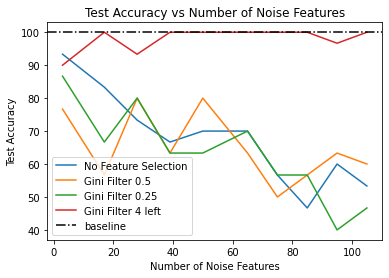

In [926]:
plt.plot(total_features, accs, label='No Feature Selection')
plt.plot(total_features, gini_accs, label='Gini Filter 0.5')
plt.plot(total_features, gini_quarter_accs, label='Gini Filter 0.25')
plt.plot(total_features, gini_4left, label='Gini Filter 4 left')
plt.axhline(y=100, xmin=0, xmax=100, color='k', linestyle='-.', label='baseline')
plt.xlabel('Number of Noise Features')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Number of Noise Features')
plt.legend()
plt.show()

__The performance of Gini-Impurity Filter is Highly sensitive to the threshhold__
As shown above, only if we know how many real informative feature are there, gini-impurity filter can successively filter out feature noise.

--- 
## Can STG mitigate this ？

In [978]:
from Model import STGEmbModel

In [1013]:
class ScikitClfWrapper:
    def __init__(self,  input_dim, number_of_classes, 
                 hidden_dims, sigma=1.0, lam=0.0,
                 batch_norm=None, dropout=None, activation='relu',
                 flatten=True, 
                 epochs=500, lr=1e-2, 
                 device='cpu', verbose=False,
                 freeze_at=0):
        self.model = STGEmbModel(
            input_dim=input_dim, output_dim=number_of_classes, activation=activation,
            hidden_dims=hidden_dims, sigma=sigma, lam=lam,
            batch_norm=batch_norm, dropout=dropout, flatten=flatten)
        self.epochs = epochs
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.device = torch.device(device)
        self.verbose = verbose
        self.freeze_at = freeze_at
        
    def fit(self, X, y):
        self.model.train()
        dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.int64))
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
        for e in range(self.epochs):
            if e <= self.freeze_at:
                self.model.freeze_fs()
            else:
                self.model.unfreeze_fs()
            train_loss = 0
            for x, y in train_loader:
                self.optimizer.zero_grad()
                x = x.to(self.device)
                y = y.to(self.device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                # loss = criterion(outputs, labels)
                loss = self.criterion(y_pred, y)
                reg_loss = self.model.get_reg_loss()
                total_loss = loss + reg_loss
                total_loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                _, num_feat = self.model.get_gates()
            if self.verbose:
                print(f'Epoch {e+1}/{self.epochs} Loss: {train_loss/len(train_loader)} num_feat: {num_feat} Reg Loss: {reg_loss}')
            
    def predict(self, X):
        self.model.eval()
        dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        for x in test_loader:
            x = x[0].to(self.device)
            y_pred = self.model(x)
            y_pred = torch.nn.functional.log_softmax(y_pred, dim=1)
            return y_pred.argmax(dim=1).numpy()


In [986]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X, y = shap.datasets.iris()
X, y = X.to_numpy().astype(np.float32), y.astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
clf = ScikitClfWrapper(
    input_dim=X.shape[1],
    number_of_classes=3,
    hidden_dims=(16, 16))
clf.fit(X_train, Y_train)

In [987]:
print_accuracy(clf.predict, X_test, y_test)

Accuracy = 100.0%


100.0

In [1047]:
X, y = shap.datasets.iris()
accs_stg = []
num_feats = []
num_normal = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_overwhelmed = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
num_shortcut = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
for i in range(10):
    X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=num_normal[i],
        num_overwhelemed=num_overwhelmed[i], num_shortcut=num_shortcut[i])
    # X_train, X_test, Y_train, Y_test = X_train.numpy(), X_test.numpy(), Y_train.numpy(), Y_test.numpy()
    X_train, y_train = X_train.to_numpy().astype(np.float32), Y_train.astype(np.int64)
    X_test, y_test = X_test.to_numpy().astype(np.float32), Y_test.astype(np.int64)
    clf = ScikitClfWrapper(
        input_dim=X_train.shape[1],
        number_of_classes=3,
        hidden_dims=(16, 16), lam=0.3, epochs=600, 
        freeze_at=10)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    num_feat = clf.model.get_gates()[1]
    num_feats.append(num_feat)
    accs_stg.append(acc)
    total_feature = num_normal[i] + num_overwhelmed[i] + num_shortcut[i]
    print(f"{acc}%, {num_feat}/{total_feature+4} features")

Accuracy = 90.0%
90.0%, 5/21 features
Accuracy = 86.66666666666667%
86.66666666666667%, 10/31 features
Accuracy = 80.0%
80.0%, 22/41 features
Accuracy = 80.0%
80.0%, 40/51 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 80.0%
80.0%, 29/61 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 70.0%
70.0%, 50/71 features
Accuracy = 63.333333333333336%
63.333333333333336%, 44/81 features
Accuracy = 60.0%
60.0%, 108/91 features
Accuracy = 66.66666666666667%
66.66666666666667%, 84/101 features
Accuracy = 56.666666666666664%
56.666666666666664%, 121/111 features


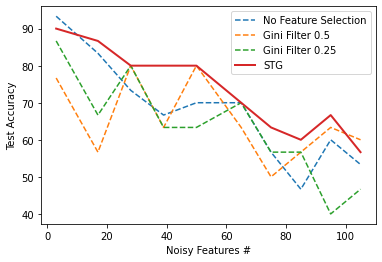

In [1048]:
plt.plot(total_features, accs,  '--', label='No Feature Selection')
plt.plot(total_features, gini_accs, '--', label='Gini Filter 0.5')
plt.plot(total_features, gini_quarter_accs, '--', label='Gini Filter 0.25')
plt.plot(total_features, accs_stg, label='STG', linewidth=2)
plt.xlabel('Noisy Features #')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()


## Reproducibility?
Fixed random seed, Decrese Interval, Smoother Curves

---
## Can two-step method mitigate this?

In [1062]:
X, y = shap.datasets.iris()
accs_twostep_stg = []
num_feats = []
num_normal = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_overwhelmed = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
num_shortcut = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
for i in range(10):
    X_train, X_test, Y_train, Y_test = insert_feature_noise(X, y, num_normal=num_normal[i],
        num_overwhelemed=num_overwhelmed[i], num_shortcut=num_shortcut[i])
    # X_train, X_test, Y_train, Y_test = X_train.numpy(), X_test.numpy(), Y_train.numpy(), Y_test.numpy()
    
    X_train, X_test, Y_train, Y_test = gini_filter(torch.tensor(X_train.values), torch.tensor(X_test.values), 
        torch.tensor(Y_train, dtype=torch.int64), 
        torch.tensor(Y_test, dtype=torch.int64), 
        left=max(4, X_train.shape[1]*0.5))
    X_train, X_test, Y_train, Y_test = X_train.numpy(), X_test.numpy(), Y_train.numpy(), Y_test.numpy()
    X_train, Y_train = X_train.astype(np.float32), Y_train.astype(np.int64)
    X_test, Y_test = X_test.astype(np.float32), Y_test.astype(np.int64)
    clf = ScikitClfWrapper(
        input_dim=X_train.shape[1],
        number_of_classes=3,
        hidden_dims=(16, 16), lam=0.3, epochs=600, 
        freeze_at=10)
    clf.fit(X_train, Y_train)
    acc = print_accuracy(clf.predict, X_test, Y_test)
    num_feat = clf.model.get_gates()[1]
    num_feats.append(num_feat)
    accs_twostep_stg.append(acc)
    total_feature = num_normal[i] + num_overwhelmed[i] + num_shortcut[i]
    print(f"{acc}%, {num_feat}/{X_train.shape[1]} features")

Accuracy = 93.33333333333333%
93.33333333333333%, 8/31 features
Accuracy = 86.66666666666667%
86.66666666666667%, 13/51 features
Accuracy = 86.66666666666667%
86.66666666666667%, 17/71 features
Accuracy = 76.66666666666667%
76.66666666666667%, 40/91 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 96.66666666666667%
96.66666666666667%, 38/111 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy = 66.66666666666667%
66.66666666666667%, 48/131 features
Accuracy = 63.333333333333336%
63.333333333333336%, 85/151 features
Accuracy = 66.66666666666667%
66.66666666666667%, 110/171 features
Accuracy = 70.0%
70.0%, 111/191 features
Accuracy = 63.333333333333336%
63.333333333333336%, 119/211 features


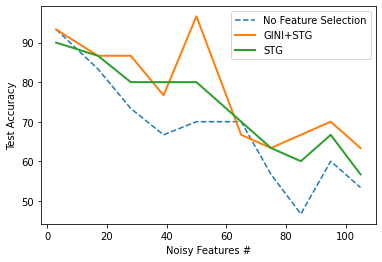

In [1063]:
plt.plot(total_features, accs,  '--', label='No Feature Selection')
# plt.plot(total_features, gini_accs, '--', label='Gini Filter 0.5')
# plt.plot(total_features, gini_quarter_accs, '--', label='Gini Filter 0.25')
plt.plot(total_features, accs_twostep_stg, label='GINI+STG', linewidth=2)
plt.plot(total_features, accs_stg, label='STG', linewidth=2)
plt.xlabel('Noisy Features #')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Increase repoducibility